# Entry G13: Weighted Degree Comparison

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('once')

from neo4j import GraphDatabase

In [4]:
uri = "bolt://localhost:7687"

driver = GraphDatabase.driver(uri, auth=('neo4j', 'password'))

uni_session = driver.session(database="unimodal")
bi_session = driver.session(database="bimodal")
mix_session = driver.session(database="mixmodal")

## Weighted Degree Count

### Hero to Hero

In [5]:
pd.DataFrame(uni_session.run('''MATCH ()-[r]-()
With distinct(r)
RETURN sum(r.weight) as weighted_degree''').data(
)).transpose().rename(columns={0:'unimodal_pm_weight'}).merge(
pd.DataFrame(bi_session.run('''MATCH (h1:Hero)-[]-(c:Comic)-[]-(h2:Hero)
WHERE id(h1) > id(h2)
RETURN count(c) as weighted_degree''').data(
)).transpose().rename(columns={0:'bimodal_pattern_match'}), right_index=True, left_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH ()-[r]-()
With distinct(r)
RETURN sum(r.weight) as weighted_degree''').data(
)).transpose().rename(columns={0:'mixmodal_pm_weight'}), right_index=True, left_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (h1:Hero)-[]-(c:Comic)-[]-(h2:Hero)
WHERE id(h1) > id(h2)
RETURN count(c) as weighted_degree''').data(
)).transpose().rename(columns={0:'mixmodal_pattern_match'}), right_index=True, left_index=True)

,unimodal_pm_weight,bimodal_pattern_match,mixmodal_pm_weight,mixmodal_pattern_match
weighted_degree,579171,579171,579171,579171


### Comic to Comic

In [4]:
pd.DataFrame(bi_session.run('''MATCH (c1:Comic)-[]-(h:Hero)-[]-(c2:Comic)
WHERE id(c1) > id(c2)
RETURN count(h) as weighted_degree''').data(
)).transpose().rename(columns={0:'bimodal_pattern_match'}).merge(
pd.DataFrame(mix_session.run('''MATCH (c1:Comic)-[]-(h:Hero)-[]-(c2:Comic)
WHERE id(c1) > id(c2)
RETURN count(h) as weighted_degree''').data(
)).transpose().rename(columns={0:'mixmodal_pattern_match'}), right_index=True, left_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bimodal_pattern_match,mixmodal_pattern_match
weighted_degree,11976783,11976783


### Bimodal double checks

#### Hero to Hero

In [5]:
double_check = pd.DataFrame(bi_session.run('''MATCH (h1:Hero)-[]-(c:Comic)-[]-(h2:Hero)
RETURN h1.name, count(c) as node_degree
''').data())
double_check.head(3)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,h1.name,node_degree
0,"FROST, CARMILLA",138
1,G'RATH,5
2,KILLRAVEN/JONATHAN R,152


In [6]:
sum(double_check['node_degree'])/2

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


579171.0

#### Comic to Comic

In [8]:
double_check2 = pd.DataFrame(bi_session.run('''MATCH (c1:Comic)-[]-(h:Hero)-[]-(c2:Comic)
RETURN c1.name, count(h) as node_degree
''').data())
double_check2.head(3)

,c1.name,node_degree
0,M/PRM 37,8
1,M/PRM 36,8
2,M/PRM 35,8


In [9]:
sum(double_check2['node_degree'])/2

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11976783.0

## Summary Statistics

### Hero to Hero

In [10]:
pd.DataFrame(uni_session.run('''MATCH (n)
OPTIONAL MATCH (n)-[r]-(m)
with n.name as hero, sum(r.weight) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'unimodal_pattern_match'}).merge(
pd.DataFrame(uni_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
    KNOWS: {
      type: 'KNOWS',
      orientation:'UNDIRECTED',
      properties:'weight'
  }},
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'unimodal_gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (h:Hero)
OPTIONAL MATCH (h)-[]-(c:Comic)-[]-(h2:Hero)
WITH h.name as hero, count(c) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'bimodal_pattern_match'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Hero)
OPTIONAL MATCH (n)-[r:KNOWS]-(m)
with n.name as hero, sum(r.weight) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'mixmodal_KNOWS_match'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Hero)
OPTIONAL MATCH (n)-[r]-(m)
with n.name as hero, sum(r.weight) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'mixmodal_pattern_match'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
    KNOWS: {
      type: 'KNOWS',
      orientation:'UNDIRECTED',
      properties:'weight'
  }},
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'mixmodal_gds_function'}), left_index=True, right_index=True)

,unimodal_pattern_match,unimodal_gds_function,bimodal_pattern_match,mixmodal_KNOWS_match,mixmodal_pattern_match,mixmodal_gds_function
weighted_degree_min,0.00,0.00,0.00,0.00,0.00,0.00
weighted_degree_max,16057.00,16057.00,16057.00,16057.00,16057.00,16057.00
weighted_degree_avg,179.89,179.89,179.89,179.89,179.89,179.89
weighted_degree_stdev,727.36,727.36,727.36,727.36,727.36,727.36


### Comic to Comic

In [11]:
pd.DataFrame(bi_session.run('''MATCH (c:Comic)
OPTIONAL MATCH (c)--(h:Hero)--(c2:Comic)
WITH c.name as comic, count(h) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'bimodal_pattern_match'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Comic)
OPTIONAL MATCH (n)--(h:Hero)--(n2:Comic)
with n.name as comic, count(h) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data(
)).transpose().rename(columns={0:'mixmodal_pattern_match'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bimodal_pattern_match,mixmodal_pattern_match
weighted_degree_min,0.00,0.00
weighted_degree_max,27582.00,27582.00
weighted_degree_avg,1893.41,1893.41
weighted_degree_stdev,2119.31,2119.31


## Degree Distribution

#### Weighted Degree DataFrames

In [14]:
uni_hero2hero = pd.DataFrame(uni_session.run('''MATCH (n)
OPTIONAL MATCH (n)-[r]-(m)
RETURN n.name as hero, sum(r.weight) as weighted_degree''').data())

bi_hero2hero = pd.DataFrame(bi_session.run('''MATCH (h:Hero)
OPTIONAL MATCH (h)-[]-(c:Comic)-[]-(h2:Hero)
RETURN h.name as hero, count(c) as weighted_degree''').data())

mix_hero2hero = pd.DataFrame(mix_session.run('''MATCH (n:Hero)
OPTIONAL MATCH (n)-[r]-(m)
RETURN n.name as hero, sum(r.weight) as weighted_degree''').data())

In [15]:
bi_comic2comic = pd.DataFrame(bi_session.run('''MATCH (c:Comic)
OPTIONAL MATCH (c)--(h:Hero)--(c2:Comic)
RETURN c.name as comic, count(h) as weighted_degree
ORDER BY comic''').data())

mix_comic2comic = pd.DataFrame(mix_session.run('''MATCH (c:Comic)
OPTIONAL MATCH (c)--(h:Hero)--(c2:Comic)
RETURN c.name as comic, count(h) as weighted_degree
ORDER BY comic''').data())

#### Unweighted Degree DataFrames

In [22]:
h2h_degree = pd.DataFrame(uni_session.run('''MATCH (h)
RETURN h.name as hero, size((h)--()) as degree''').data())

c2c_degree = pd.DataFrame(bi_session.run('''MATCH (c1:Comic)
OPTIONAL MATCH (c1)<-[]-(h)-[]->(c2)
RETURN c1.name as comic, count(distinct c2) as degree''').data())

## Hero to Hero

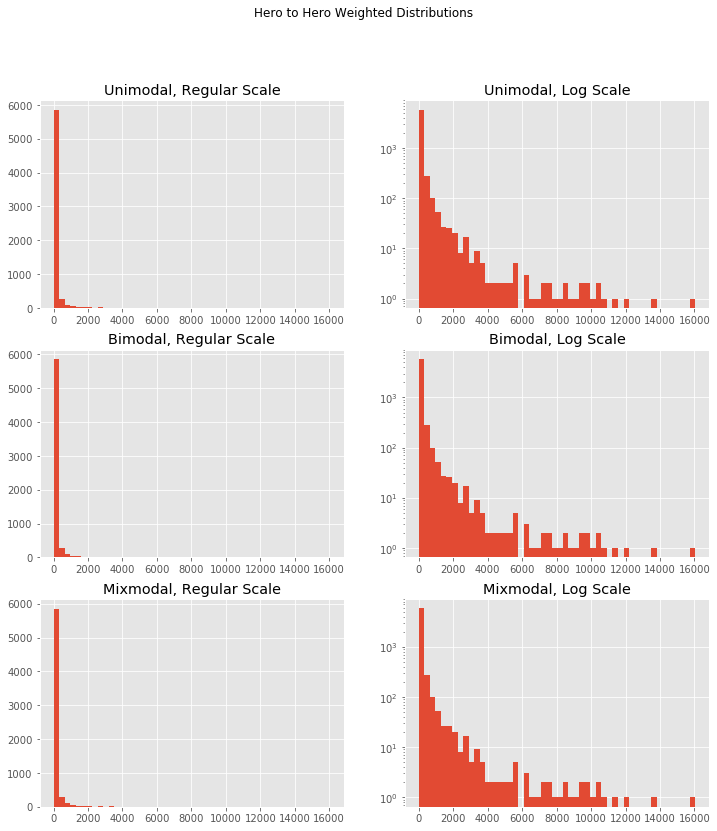

In [21]:
h2h_fig, h2h_axes = plt.subplots(3, 2, figsize=(12,13))
h2h_fig.suptitle("Hero to Hero Weighted Distributions")
h2h_axes[0,0].hist(uni_hero2hero['weighted_degree'], bins=50)
h2h_axes[0,0].set_title('Unimodal, Regular Scale')
h2h_axes[0,1].hist(uni_hero2hero['weighted_degree'], bins=50)
h2h_axes[0,1].set_yscale('log')
h2h_axes[0,1].set_title('Unimodal, Log Scale')
h2h_axes[1,0].hist(bi_hero2hero['weighted_degree'], bins=50)
h2h_axes[1,0].set_title('Bimodal, Regular Scale')
h2h_axes[1,1].hist(bi_hero2hero['weighted_degree'], bins=50)
h2h_axes[1,1].set_yscale('log')
h2h_axes[1,1].set_title('Bimodal, Log Scale')
h2h_axes[2,0].hist(mix_hero2hero['weighted_degree'], bins=50)
h2h_axes[2,0].set_title('Mixmodal, Regular Scale')
h2h_axes[2,1].hist(mix_hero2hero['weighted_degree'], bins=50)
h2h_axes[2,1].set_yscale('log')
h2h_axes[2,1].set_title('Mixmodal, Log Scale')
plt.show()

## Comic to Comic

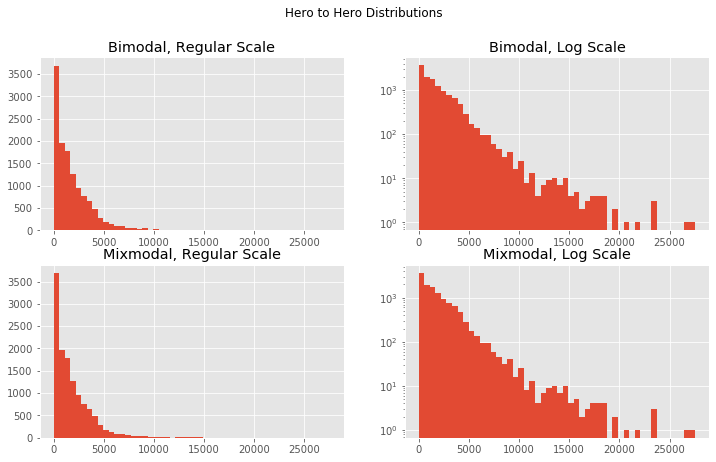

In [20]:
c2c_fig, c2c_axes = plt.subplots(2, 2, figsize=(12,7))
c2c_fig.suptitle("Hero to Hero Distributions")
c2c_axes[0,0].hist(bi_comic2comic['weighted_degree'], bins=50)
c2c_axes[0,0].set_title('Bimodal, Regular Scale')
c2c_axes[0,1].hist(bi_comic2comic['weighted_degree'], bins=50)
c2c_axes[0,1].set_yscale('log')
c2c_axes[0,1].set_title('Bimodal, Log Scale')
c2c_axes[1,0].hist(mix_comic2comic['weighted_degree'], bins=50)
c2c_axes[1,0].set_title('Mixmodal, Regular Scale')
c2c_axes[1,1].hist(mix_comic2comic['weighted_degree'], bins=50)
c2c_axes[1,1].set_yscale('log')
c2c_axes[1,1].set_title('Mixmodal, Log Scale')
plt.show()

## Unweighted vs Weighted Distributions - Log Scale

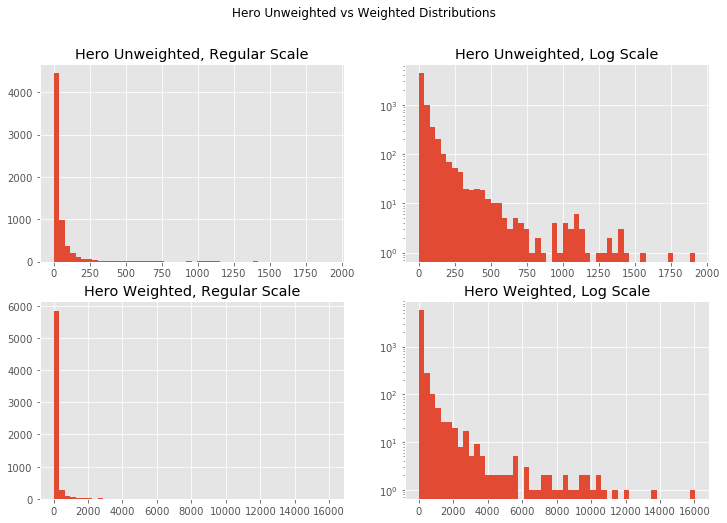

In [31]:
h2h_fig, h2h_axes = plt.subplots(2, 2, figsize=(12,8))
h2h_fig.suptitle("Hero Unweighted vs Weighted Distributions")
h2h_axes[0,0].hist(h2h_degree['degree'], bins=50)
h2h_axes[0,0].set_title('Hero Unweighted, Regular Scale')
h2h_axes[0,1].hist(h2h_degree['degree'], bins=50)
h2h_axes[0,1].set_yscale('log')
h2h_axes[0,1].set_title('Hero Unweighted, Log Scale')
h2h_axes[1,0].hist(uni_hero2hero['weighted_degree'], bins=50)
h2h_axes[1,0].set_title('Hero Weighted, Regular Scale')
h2h_axes[1,1].hist(uni_hero2hero['weighted_degree'], bins=50)
h2h_axes[1,1].set_yscale('log')
h2h_axes[1,1].set_title('Hero Weighted, Log Scale')
plt.show()

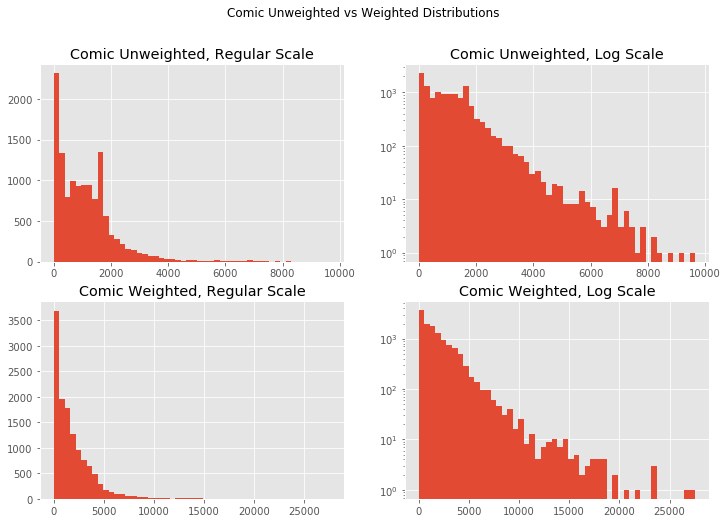

In [30]:
c2c_fig, c2c_axes = plt.subplots(2, 2, figsize=(12,8))
c2c_fig.suptitle("Comic Unweighted vs Weighted Distributions")
c2c_axes[0,0].hist(c2c_degree['degree'], bins=50)
c2c_axes[0,0].set_title('Comic Unweighted, Regular Scale')
c2c_axes[0,1].hist(c2c_degree['degree'], bins=50)
c2c_axes[0,1].set_yscale('log')
c2c_axes[0,1].set_title('Comic Unweighted, Log Scale')
c2c_axes[1,0].hist(bi_comic2comic['weighted_degree'], bins=50)
c2c_axes[1,0].set_title('Comic Weighted, Regular Scale')
c2c_axes[1,1].hist(bi_comic2comic['weighted_degree'], bins=50)
c2c_axes[1,1].set_yscale('log')
c2c_axes[1,1].set_title('Comic Weighted, Log Scale')
plt.show()